In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
import pickle
import xgboost as xgb
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.feature_selection import SelectPercentile, f_regression
from time import time, strftime, localtime

In [2]:
# Load data
train_df = pd.read_csv("../dataset/train.csv")
test_df = pd.read_csv("../dataset/test.csv")
submit_test_df = pd.read_csv("../dataset/submit_test.csv")

In [3]:
# Split data & process missing value

# Fill nan with "0.0"
train_fillna_df = train_df.iloc[:,1:-1].fillna(value=0.0)
test_fillna_df = test_df.iloc[:,1:].fillna(value=0.0)
all_fillna_df = pd.concat((train_fillna_df, test_fillna_df), axis = 0)

# Fill nan with "median"
#train_fillna_df = train_df.iloc[:,1:-1].fillna(train_df.iloc[:,1:-1].median())
#test_fillna_df = test_df.iloc[:,1:].fillna(test_df.iloc[:,1:].median())
#all_fillna_df = pd.concat((train_fillna_df, test_fillna_df), axis = 0)

label_name = "total_price"
label_df = pd.DataFrame(train_df[label_name])

In [30]:
# Create features
# [house_age: the age of house on purchased date, ((成交日 - 完工日) / 365) ((txn_dt - building_complete_dt) / 365)]
all_createCol_df = all_fillna_df.assign(house_age = round((all_fillna_df["txn_dt"] - all_fillna_df["building_complete_dt"]) / 3650, 0))
# [txn_year: the year of trade, 成交日 / 365, txn_dt / 365]
all_createCol_df = all_createCol_df.assign(txn_year = round((all_fillna_df["txn_dt"] / 365), 0))
# [floor_of_building: floor of building, 交易樓層 / 總樓層(txn_floor / total_floor)]，如 txn_floor 為 0，代表建物不為一層，以總樓層帶入
all_createCol_df = all_createCol_df.assign(floor_of_building = all_fillna_df["txn_floor"] / all_fillna_df["total_floor"])
all_createCol_df["floor_of_building"][all_createCol_df["txn_floor"] == 0] = all_fillna_df["total_floor"]

/Users/peteryoung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
inf = float("inf")

# [sales_per_unit_area 坪效: 一坪土地可蓋出多少坪可銷售面積, (建物面積 / 土地面積), (building_area / land_area)]
all_createCol_df = all_createCol_df.assign(sales_per_unit_area = round(all_createCol_df["building_area"] / all_createCol_df["land_area"], 1))
all_createCol_df["sales_per_unit_area"][all_createCol_df["sales_per_unit_area"] == inf] = all_createCol_df["sales_per_unit_area"].median()

# [power_pos_rate 強化正相關率: 將會提高房價的因素加總，再減會減低房價的因素, (所在縣市出生率 + 所在縣市結婚率 - 所在縣市死亡率), (born_rate + marriage_rate - death_rate)]
all_createCol_df = all_createCol_df.assign(power_pos_rate = all_createCol_df["born_rate"] + all_createCol_df["marriage_rate"] - all_createCol_df["death_rate"])
all_createCol_df = all_fillna_df.assign(power_pos_rate = all_fillna_df["born_rate"] + all_fillna_df["marriage_rate"] - all_fillna_df["death_rate"])

# [high_edu_rate 各縣市高學歷率: 各縣市的高學歷加總比率(大學含以上)]
all_createCol_df = all_createCol_df.assign(high_edu_rate = round(all_createCol_df["doc_rate"] + all_createCol_df["master_rate"] + all_createCol_df["bachelor_rate"], 3))

# [low_edu_rate 各縣市低學歷率: 各縣市的低學歷加總比率(專科+高中含以下)]
all_createCol_df = all_createCol_df.assign(low_edu_rate = round(all_createCol_df["jobschool_rate"] + all_createCol_df["highschool_rate"] + all_createCol_df["junior_rate"] + all_createCol_df["elementary_rate"], 3))

# [is_apartment_first_top 是否為公寓的一樓跟頂樓: 公寓的一樓跟頂樓最貴]
all_createCol_df = all_createCol_df.assign(is_apartment_first_top = 0.0)
all_createCol_df["is_apartment_first_top"][(all_createCol_df["building_type"] == 1) & ((all_createCol_df["txn_floor"] == 1) |  (all_createCol_df["txn_floor"] == all_createCol_df["total_floor"]))] = 1

# [is_0_3_high_floor 是否為電梯大樓、華廈的高樓層(7樓以上): 樓層越高越貴]
all_createCol_df = all_createCol_df.assign(is_0_3_high_floor = 0.0)
all_createCol_df["is_0_3_high_floor"][((all_createCol_df["building_type"] == 0) | (all_createCol_df["building_type"] == 3)) & (all_createCol_df["txn_floor"] >= 7)] = 1

# [_0_3_high_floor_rate 電梯大樓、華廈的高樓層高度比率(7樓以上): 樓層越高越貴]
all_createCol_df = all_createCol_df.assign(_0_3_high_floor_rate = 0.0)
all_createCol_df["_0_3_high_floor_rate"][((all_createCol_df["building_type"] == 0) | (all_createCol_df["building_type"] == 3)) & (all_createCol_df["txn_floor"] >= 7)] = (all_fillna_df["txn_floor"] / all_fillna_df["total_floor"])

In [42]:
all_createCol_df["_0_3_high_floor_rate"].head()

0    0.000000
1    0.000000
2    0.000000
3    0.541667
4    0.000000
Name: _0_3_high_floor_rate, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a31fae3c8>]],
      dtype=object)

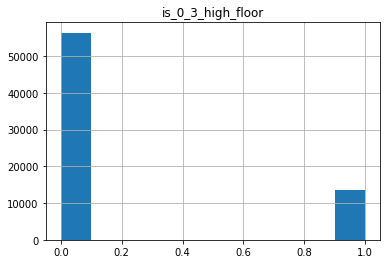

In [38]:
all_createCol_df[["is_0_3_high_floor"]].hist()

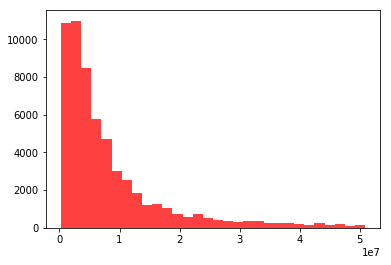

In [109]:
# the histogram of the data
x_array = train_df["total_price"]
n, bins, patches = plt.hist(x_array, 30, density=False, facecolor='r', alpha=0.75, range = (226149.5, 50882790))

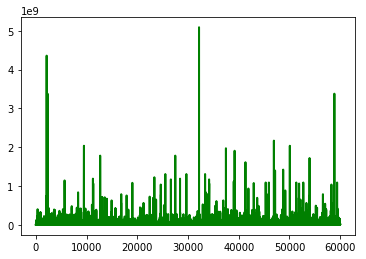

In [136]:
plt.plot(np.arange(1,60001),x_array, color='green', linestyle='solid', linewidth=2)

In [81]:
all_createCol_df["house_age"].describe()

count    70000.000000
mean         2.310157
std          1.242203
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: house_age, dtype: float64